In [16]:
!pip install trimesh


In [17]:


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils import data
from torch.utils.data import Dataset, Sampler
from torch.utils.data import TensorDataset, DataLoader
import random
import time
import itertools
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR # *
torch.set_num_threads(1)
import pandas as pd
from skimage import measure
import trimesh


In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0')


In [20]:
# dataloader
class dataset(Dataset):
    def __init__(self,item_lists, npoints=2048):
        self.filelist = item_lists #[item for item in os.listdir(path) if item[-4:] == '.npy']
        self.npoints = npoints

    def __len__(self):
        return len(self.filelist)

    # 45% inside, 45% outside, 10% sphere
    def __getitem__(self, idx):
        file = self.filelist[idx]
        data = np.load(file).squeeze()
        np.random.shuffle(data)
        data = data[:self.npoints]
        return data, idx

In [21]:
from google.colab import files
uploaded = files.upload()

Saving lc.pth to lc (1).pth
Saving sdf.pth to sdf (1).pth


In [ ]:
item_lists = list(['cylinder.npy', 'sphere.npy'])

In [ ]:
#item_lists

In [ ]:
num_augment_pts = 1024
train_dataset = dataset(item_lists, num_augment_pts)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 2, shuffle=True)

In [22]:
class Embedd(nn.Module):
    def __init__(self, N, dim):
        super(Embedd, self).__init__()
        self.N = N
        self.dim = dim
        self.embed_params = nn.Parameter(torch.Tensor(N, dim))
        self.reset_parameters()

    def reset_parameters(self):
        init_std = 1.0 / np.sqrt(self.dim)

        torch.nn.init.normal_(
            self.embed_params.data,
            0.0,
            init_std,
        )

    def forward(self, idx):
        batch_embed = self.embed_params[idx]
        return {'latent_code': batch_embed}

In [23]:
class Net(nn.Module):

    def __init__(self, lc_dim = 16, h_dim = 50):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(lc_dim + 3, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x


In [24]:
N = 2; lc_dim = 16
epochs = 3000
lc_d = 16
llr = 0.001
h_dim = 64
nlr = 0.001


In [25]:
latent_embedding = Embedd(N, lc_d).to(device)
net = Net(lc_d,h_dim).to(device)

## Training

In [ ]:



optim        = torch.optim.Adam(net.parameters(), lr=nlr, betas=[0.9,0.999], eps=1.0e-12, weight_decay=0.1, amsgrad=False)
scheduler    = StepLR(optim, step_size=500, gamma=0.5)#LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

optim_lc = torch.optim.Adam(latent_embedding.parameters(), lr=llr, betas=[0.9,0.999], eps=1.0e-12, weight_decay=0.1, amsgrad=False)
scheduler_lc = StepLR(optim_lc, step_size=500, gamma=0.5)#LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

with tqdm(range(epochs)) as pbar:
    vv = []
    net.train()
    latent_embedding.train()
    loss = nn.L1Loss()

    for epoch in pbar:
        for bidx, (data, idx) in enumerate(train_loader):
            optim.zero_grad()
            coords = data[..., :3].to(device)
            sdf_gt = data[..., 3].to(device)
            latent_codes = latent_embedding(idx)['latent_code'].unsqueeze(1).repeat(1,num_augment_pts,1).to(device)
           # print(latent_embedding(idx)['latent_code'].shape, latent_codes.shape, coords.shape)
            lc_coords = torch.cat([latent_codes, coords], axis = 2)
            # forward and calculate loss
            model_output = net(lc_coords).squeeze()

            train_loss = torch.sqrt(torch.sum((sdf_gt - model_output)**2))
            pbar.set_description("loss: {:.6f}".format(train_loss.item()))

            # backward
            train_loss.backward()
            optim.step()
            scheduler.step()

            optim_lc.step()
            scheduler_lc.step()
            vv.append(train_loss.item())

loss: 0.418140: 100%|██████████| 3000/3000 [1:07:27<00:00,  1.35s/it]


In [ ]:
save_name = "sdf.pth"
path = os.path.join('./', save_name)
torch.save(net.state_dict(), path)

save_name = "lc.pth"
path = os.path.join('./', save_name)
torch.save(latent_embedding.state_dict(), path)

In [ ]:
plt.plot(vv)

## Inference


In [26]:
net.load_state_dict(torch.load('./sdf.pth'))
latent_embedding.load_state_dict(torch.load('./lc.pth'))

<All keys matched successfully>

In [27]:
def get_grid_points(reso, scale):
    coords = np.mgrid[:reso, :reso, :reso]
    coords = coords.reshape(3, -1).T
    coords = scale * (2 * (coords / reso) - 1)

    return coords

In [28]:
#dir(latent_embedding)

In [29]:
reso = 64
coords_scale = 1.2
coords = get_grid_points(reso, coords_scale)
coords = torch.FloatTensor(coords).to(device)

In [30]:
idx = 0
latent_codes = latent_embedding(idx)['latent_code'].to(device)
print(latent_codes.shape)
voxel = np.array([])
step = reso ** 2
#tmp = torch.FloatTensor(latent_codes).to(device).unsqueeze(0).repeat((step, 1))
#tmp = tmp.unsqueeze(0)
latent_codes = latent_codes.unsqueeze(0)
latent_codes = latent_codes.unsqueeze(1).repeat(1, step, 1)
for b in range(reso ** 3 // step):
    coords_batch = coords[b * step: (b + 1) * step]
    coords_batch = coords_batch.unsqueeze(0)

    lc_coords = torch.cat([latent_codes, coords_batch], axis = 2)
    # forward and calculate loss
    model_output = net(lc_coords).squeeze()

    output = model_output.detach().cpu().numpy()
    voxel = np.append(voxel,output)
voxel = voxel.reshape(reso,reso,reso)
np.save("./{}.npy".format(idx),voxel)


torch.Size([16])


In [31]:
vertices, faces, normals, values = measure.marching_cubes(
        voxel, level=0.0, spacing=[1] * 3,step_size = 1,
        gradient_direction='descent', method ='lewiner',allow_degenerate = True
    )
mesh = trimesh.Trimesh(vertices = vertices, faces = faces)
mesh.export('{}.stl'.format(idx));


In [32]:
mesh.export('{}.stl'.format(idx));


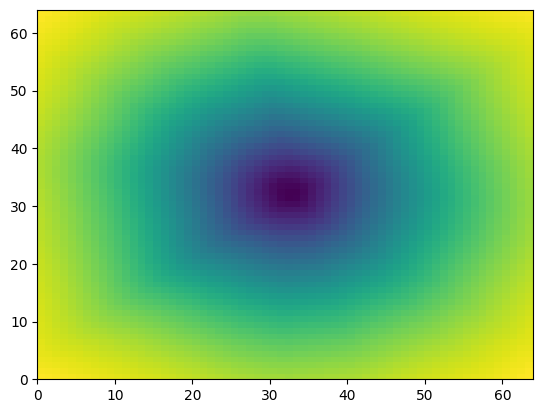

In [33]:
vox = np.load('./{}.npy'.format(idx))
plt.pcolor(vox[:,:,16])